# CSE253 PA3 - Design a CNN 

First a bit of setup!!!

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim.lr_scheduler import StepLR

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import timeit
import time
import platform
import random
import pickle as pickle

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())

Python version:  3.5.4


## Load Datasets

We load the CIFAR-10 dataset. This might take a couple minutes the first time you do it, but the files should stay cached after that.

In [73]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 40000
NUM_VAL = 10000

cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=T.ToTensor())
loader_train = (DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN, 0)))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=T.ToTensor())
loader_val = (DataLoader(cifar10_val, batch_size=64, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN)))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True,
                          transform=T.ToTensor())
loader_test = (DataLoader(cifar10_test, batch_size=64))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Our image data (and more relevantly, our intermediate feature maps) are initially N x C x H x W, where:

* N is the number of datapoints  
* C is the number of channels  
* H is the height of the intermediate feature map in pixels  
* W is the height of the intermediate feature map in pixels  

This is the right way to represent the data when we are doing something like a 2D convolution, that needs spatial understanding of where the intermediate features are relative to each other. When we input data into fully connected affine layers, however, we want each datapoint to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data. So, we use a "Flatten" operation to collapse the C x H x W values per representation into a single long vector. The Flatten function below first reads in the N, C, H, and W values from a given batch of data, and then returns a "view" of that data. "View" is analogous to numpy's "reshape" method: it reshapes x's dimensions to be N x ??, where ?? is allowed to be anything (in this case, it will be C x H x W, but we don't need to specify that explicitly).

In [3]:
dtype = torch.FloatTensor # the CPU datatype
gpu_dtype = torch.cuda.FloatTensor

# Constant to control how frequently we print train loss
print_every = 100

# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
        
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [83]:
def train(model, loss_fn, optimizer, num_epochs = 1, verbose=False):

    scheduler = StepLR(optimizer, step_size=5, gamma=0.9)    
    
    for epoch in range(num_epochs):
        if verbose:
            print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
            
        scheduler.step()    
        model.train()
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0 and verbose:
                print('t = %d, loss = %.6f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def train_detailed(model, loss_fn, optimizer, reg, num_epochs = 10, verbose=False):
    # Train the model in greater detail - output validation and train accuracy every epoch
    
    train_history = []   # this will store train accuracy, val accuracy and loss for every epoch
    best_val_acc = 0.0  # initialize best_val_acc

    scheduler = StepLR(optimizer, step_size=5, gamma=0.9)   # decay lr by 0.9 very 5 epochs 
    
    for epoch in range(num_epochs):
        if verbose:
            print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
            
        scheduler.step()    
        model.train()
        lossSum = 0
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            lossSum += loss.data[0]
            if (t + 1) % print_every == 0 and verbose:
                print('t = %d, loss = %.6f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
       
        # We calculate validation and training accuracy at the end of every epoch
        val_acc = check_accuracy(model, loader_val) 
        train_acc = check_accuracy(model, loader_train)
        print ("train acc: {} val acc:{}".format(train_acc,val_acc))
        val_loss = check_loss(model,loader_val,verbose)

        if val_acc > best_val_acc:  
            # save your model 
            file_name = 'model_reg='+str(reg)+'bestacc.pt'
            torch.save(model.state_dict(), file_name)
            best_val_acc = val_acc 
        
        print("progress is as such:",[train_acc,val_acc, lossSum/t, val_loss])
        train_history.append([train_acc,val_acc, lossSum/t, val_loss])
        
    return best_val_acc, train_history 
            
def check_accuracy(model, loader, verbose=False):
    if verbose:
        if loader.dataset.train:
            print('Checking accuracy on validation set')
        else:
            print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype), volatile=True)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    if verbose:
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

def check_loss(model,loader,verbose):
    #calculate validation loss
    loss2sum = 0
    model.eval()
    for t, (x, y) in enumerate(loader_val):
        x_var = Variable(x.type(gpu_dtype))
        y_var = Variable(y.type(gpu_dtype).long())

        scores = model(x_var)
            
        loss2 = loss_fn(scores, y_var)
        loss2sum += loss2.data[0]
        if (t + 1) % print_every == 0 and verbose:
            print('t = %d, loss = %.6f' % (t + 1,loss2.data[0]))
    return loss2sum/t

In [84]:
"""
def generator():
    
    # Model - 4 layer Conv Layers
    
    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half        
                    Flatten(),
                    nn.Linear(8192,1024),  # 5408=128*16*16 input size
                    nn.ReLU(inplace=True),
                    nn.Linear(1024,10),
                    )
    return model


def generator():

    # Model - 5 layer Conv Layers

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half        
                    Flatten(),
                    nn.Linear(8192,1024),  # 5408=128*16*16 input size
                    nn.ReLU(inplace=True),
                    nn.Linear(1024,10),
                    )
    return model

def generator():

    Model - 6 layer Conv Layers

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),        
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half        
                    Flatten(),
                    nn.Linear(16384,1024),  # 5408=128*16*16 input size
                    nn.ReLU(inplace=True),
                    nn.Linear(1024,10),
                    )
    return model


def generator():

    # Model - 5 layer Conv Layers (WIDER)

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=256, kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half        
                    Flatten(),
                    nn.Linear(16384,1024),  # 5408=128*16*16 input siz
                    nn.ReLU(inplace=True),
                    nn.Linear(1024,10),
                    )
    return model
"""
"""
def generator():

    # Model - 10 layer Conv Layers (WIDER)

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension,1
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension,2
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension,3
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension,4
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension,5
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension,6
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension,7
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension,8
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension,9
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension,10
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    Flatten(),
                    nn.Linear(131072,1024),  # 5408=128*32*32 input siz
                    nn.ReLU(inplace=True),
                    nn.Linear(1024,10),
                    )
    return model
"""
def generator():

    # Model - 10 layer Conv Layers (WIDER)

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension,1
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension,2
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=2,padding=1), # preserve dimension,3
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension,4
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=2,padding=1), # preserve dimension,5
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension,6
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=2,padding=1), # preserve dimension,7
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension,8
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=2,padding=1), # preserve dimension,9
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=512),
                    nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1), # preserve dimension,10
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=512),
                    Flatten(),
                    nn.Linear(2048,1024),  # 5408=128*32*32 input siz
                    nn.ReLU(inplace=True),
                    nn.Linear(1024,10),
                    )
    return model

In [6]:
model = generator().type(gpu_dtype)

x_gpu = torch.randn(64, 3, 32, 32).type(gpu_dtype)
x_var_gpu = Variable(x_gpu.type(gpu_dtype)) # Construct a PyTorch Variable out of your input data
ans = model(x_var_gpu)        # Feed it through the model! 

#print (ans.shape)

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([64, 10]))

True

In [9]:
model = generator().type(gpu_dtype)
loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
optimizer = optim.Adam(model.parameters(), lr=0.00035, weight_decay=1e-10)

start = time.time()

train(model, loss_fn, optimizer, num_epochs=1)
val_acc = check_accuracy(model, loader_val)

end = time.time()
    
print('validation accuracy is {0}. Training time for 1 epoch: {1:.2f} sec'.format(val_acc, end-start))

validation accuracy is 0.657. Training time for 1 epoch: 49.54 sec


In [ ]:
stat = []

start = time.time()
max_count = 10
for count in range(max_count):
    reg = 1e-10
    lr = 10**random.uniform(-5,-2)
    
    model = generator().type(gpu_dtype)
    
    loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
    train(model, loss_fn, optimizer, num_epochs=1)
    val_acc = check_accuracy(model, loader_val)
    
    print('lr = {}, reg = {}, validation accuracy is {}  '.format(lr, reg, val_acc))
    stat.append([lr, reg, val_acc])

    end = time.time()
    
print('Training time for 10 epochs: {1:.2f} sec'.format(val_acc, end-start))

sorted_stat = sorted(stat, key=lambda x: x[0], reverse=True)
print ("In descending order of learning rate:")
for lr, reg, val_acc in sorted_stat:
    print('lr = {}, reg = {}, validation accuracy is {}  '.format(lr, reg, val_acc))    
   

lr = 0.00011168257865591311, reg = 1e-10, validation accuracy is 0.584  
lr = 0.0016268571258444234, reg = 1e-10, validation accuracy is 0.598  
lr = 5.9433379071275825e-05, reg = 1e-10, validation accuracy is 0.574  
lr = 0.002738903646489327, reg = 1e-10, validation accuracy is 0.593  
lr = 0.00023558090023171975, reg = 1e-10, validation accuracy is 0.638  
lr = 5.646663925409054e-05, reg = 1e-10, validation accuracy is 0.571  
lr = 0.004656427826351652, reg = 1e-10, validation accuracy is 0.512  
lr = 0.005440279602084457, reg = 1e-10, validation accuracy is 0.467  
lr = 0.0007473177781338236, reg = 1e-10, validation accuracy is 0.644  
lr = 0.003355945221102989, reg = 1e-10, validation accuracy is 0.495  
lr = 0.00023905473415683688, reg = 1e-10, validation accuracy is 0.653  
lr = 2.4186993215858095e-05, reg = 1e-10, validation accuracy is 0.522  
lr = 0.0009616903078556671, reg = 1e-10, validation accuracy is 0.656  
lr = 0.0034777189162263377, reg = 1e-10, validation accuracy is

# Adjust Learning Rate 

We turn down regularization (reg=1e-10), and do a coarse learning rate search over several multi-layer CNN with maxpooling.

## 14 layer covnet

lr = 0.0014332955883302268, reg = 1e-10, validation accuracy is 0.553  
lr = 0.0003488919238298938, reg = 1e-10, validation accuracy is 0.699  
lr = 0.0003106013879921905, reg = 1e-10, validation accuracy is 0.695  
lr = 0.006529508880491467, reg = 1e-10, validation accuracy is 0.098  
lr = 0.0006695355436664427, reg = 1e-10, validation accuracy is 0.667  
lr = 0.0030084157499084825, reg = 1e-10, validation accuracy is 0.386  
lr = 0.0031498218521473008, reg = 1e-10, validation accuracy is 0.297  
lr = 0.0004521058841800273, reg = 1e-10, validation accuracy is 0.687  
lr = 0.0008941778789603731, reg = 1e-10, validation accuracy is 0.613  
lr = 0.00011263526559213542, reg = 1e-10, validation accuracy is 0.714  
lr = 0.004351565396023007, reg = 1e-10, validation accuracy is 0.098  
lr = 0.009638819818568978, reg = 1e-10, validation accuracy is 0.098  
lr = 0.00046849241080962356, reg = 1e-10, validation accuracy is 0.663  
lr = 0.00013463548961918718, reg = 1e-10, validation accuracy is 0.697  
lr = 2.4948345072165963e-05, reg = 1e-10, validation accuracy is 0.656  
lr = 5.77437580640381e-05, reg = 1e-10, validation accuracy is 0.678  
lr = 0.0011608301485078573, reg = 1e-10, validation accuracy is 0.596  
lr = 0.0007377113977993159, reg = 1e-10, validation accuracy is 0.625  
lr = 0.0003554619545626375, reg = 1e-10, validation accuracy is 0.679  
lr = 0.0020421838641083946, reg = 1e-10, validation accuracy is 0.537  
Training time for 10 epochs: 1516.63 sec
In descending order of learning rate:
lr = 0.009638819818568978, reg = 1e-10, validation accuracy is 0.098  
lr = 0.006529508880491467, reg = 1e-10, validation accuracy is 0.098  
lr = 0.004351565396023007, reg = 1e-10, validation accuracy is 0.098  
lr = 0.0031498218521473008, reg = 1e-10, validation accuracy is 0.297  
lr = 0.0030084157499084825, reg = 1e-10, validation accuracy is 0.386  
lr = 0.0020421838641083946, reg = 1e-10, validation accuracy is 0.537  
lr = 0.0014332955883302268, reg = 1e-10, validation accuracy is 0.553  
lr = 0.0011608301485078573, reg = 1e-10, validation accuracy is 0.596  
lr = 0.0008941778789603731, reg = 1e-10, validation accuracy is 0.613  
lr = 0.0007377113977993159, reg = 1e-10, validation accuracy is 0.625  
lr = 0.0006695355436664427, reg = 1e-10, validation accuracy is 0.667  
lr = 0.00046849241080962356, reg = 1e-10, validation accuracy is 0.663  
lr = 0.0004521058841800273, reg = 1e-10, validation accuracy is 0.687  
lr = 0.0003554619545626375, reg = 1e-10, validation accuracy is 0.679  
lr = 0.0003488919238298938, reg = 1e-10, validation accuracy is 0.699  
lr = 0.0003106013879921905, reg = 1e-10, validation accuracy is 0.695  
lr = 0.00013463548961918718, reg = 1e-10, validation accuracy is 0.697  
lr = 0.00011263526559213542, reg = 1e-10, validation accuracy is 0.714  
lr = 5.77437580640381e-05, reg = 1e-10, validation accuracy is 0.678  
lr = 2.4948345072165963e-05, reg = 1e-10, validation accuracy is 0.656 

In [7]:
stat = []

start = time.time()
max_count = 10
for count in range(max_count):
    reg = 10**random.uniform(-10,2)
    lr = 0.0009616903078556671
    
    model = generator().type(gpu_dtype)
    
    loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
    train(model, loss_fn, optimizer, num_epochs=1)
    val_acc = check_accuracy(model, loader_val)
    
    print('lr = {}, reg = {}, validation accuracy is {}  '.format(lr, reg, val_acc))
    stat.append([lr, reg, val_acc])

    end = time.time()
    
print('Training time for 10 epochs: {1:.2f} sec'.format(val_acc, end-start))

sorted_stat = sorted(stat, key=lambda x: x[0], reverse=True)
print ("In descending order of learning rate:")
for lr, reg, val_acc in sorted_stat:
    print('lr = {}, reg = {}, validation accuracy is {}  '.format(lr, reg, val_acc)) 

lr = 0.0009616903078556671, reg = 21.272665634971855, validation accuracy is 0.079  
lr = 0.0009616903078556671, reg = 3.704329527669045e-08, validation accuracy is 0.65  
lr = 0.0009616903078556671, reg = 0.0007405454328093895, validation accuracy is 0.62  
lr = 0.0009616903078556671, reg = 2.151419606920332e-06, validation accuracy is 0.616  
lr = 0.0009616903078556671, reg = 0.00014211363631773827, validation accuracy is 0.65  
lr = 0.0009616903078556671, reg = 1.6090791737988265e-06, validation accuracy is 0.649  
lr = 0.0009616903078556671, reg = 3.477905750270434e-05, validation accuracy is 0.662  
lr = 0.0009616903078556671, reg = 9.170751933898437e-10, validation accuracy is 0.632  
lr = 0.0009616903078556671, reg = 1.946892102742311e-07, validation accuracy is 0.619  
lr = 0.0009616903078556671, reg = 1.531242980758215e-06, validation accuracy is 0.666  
Training time for 10 epochs: 168.34 sec
In descending order of learning rate:
lr = 0.0009616903078556671, reg = 21.272665634

# Finetune Learning Rate + Regularization

####  Model 5-Conv Layers, 2 MaxPool Blocks (WIDER)

Sequential(
  (0): Conv2d (3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (3): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace)
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (6): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (10): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (13): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU(inplace)
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (17): Flatten(
  )
  (18): Linear(in_features=16384, out_features=1024)
  (19): ReLU(inplace)
  (20): Linear(in_features=1024, out_features=10)
)

* Training time for 1 epoch: 13.18 sec

* In descending order of learning rate:
lr = 0.0019448764802993351, reg = 0.0014559406583695056, validation accuracy is 0.64  
lr = 0.0018436283136011092, reg = 1.20855073494988e-07, validation accuracy is 0.602  
lr = 0.0017469433543108419, reg = 0.005407562156582751, validation accuracy is 0.588  
lr = 0.0013869356779387546, reg = 5.94062005313746e-05, validation accuracy is 0.653  
lr = 0.0012393288000769702, reg = 5.12602146030666, validation accuracy is 0.113  
lr = 0.0008867992873069955, reg = 1.4372398781436804, validation accuracy is 0.199  
lr = 0.0006996954263941067, reg = 1.9038337189684477e-06, validation accuracy is 0.708  
** lr = 0.0006055829256460011, reg = 9.58996938648248e-07, validation accuracy is 0.722 **  
** lr = 0.0005443722591657279, reg = 0.00017920546701173702, validation accuracy is 0.719 **  
lr = 0.0005251670566001226, reg = 0.0018050589295523598, validation accuracy is 0.699  
lr = 0.00048459438835051166, reg = 0.05983089061009524, validation accuracy is 0.621  
lr = 0.0004420536106205546, reg = 2.0186822341150736e-06, validation accuracy is 0.768  
** lr = 0.0004122334077427315, reg = 6.4451833938235595e-09, validation accuracy is 0.747 **  
lr = 0.0003961550140640271, reg = 0.8105443384587647, validation accuracy is 0.37  
lr = 0.00037206712670449505, reg = 0.09927454316034201, validation accuracy is 0.614  
** lr = 0.000348507497041526, reg = 1.4605422936453535e-05, validation accuracy is 0.725 **  
lr = 0.0003159819304478141, reg = 28.656846959736583, validation accuracy is 0.113  
** lr = 0.00030976635881782815, reg = 1.9752562992451137e-05, validation accuracy is 0.737 **  
** lr = 0.00030255947398111444, reg = 1.1887805824295586e-07, validation accuracy is 0.732 **   
** lr = 0.0002938522880460647, reg = 3.1116344006152496e-09, validation accuracy is 0.731 **  
<span style="color:blue"> ** lr = 0.0002885154495256621, reg = 2.771973322549355e-09, validation accuracy is 0.75 ** <span style="color:black">   
lr = 0.0002719530062001166, reg = 8.181890417359118e-05, validation accuracy is 0.714  
lr = 0.00025635190472579454, reg = 26.22154832223876, validation accuracy is 0.087  
lr = 0.00016799852379122324, reg = 15.613566194573618, validation accuracy is 0.098  
** lr = 0.0001638932273529234, reg = 3.0703157061644324e-05, validation accuracy is 0.73 **  
** lr = 0.00016151175929450816, reg = 0.001461378511321383, validation accuracy is 0.73 **  
lr = 0.00015862184981477027, reg = 3.311901217036856e-07, validation accuracy is 0.72  
lr = 0.00014157475047081133, reg = 3.515875715049107e-05, validation accuracy is 0.723  
lr = 0.00011805442164972787, reg = 3.818327291174253e-10, validation accuracy is 0.716  
lr = 0.00011532989154129476, reg = 3.889665794272065, validation accuracy is 0.226  
lr = 9.609980503912395e-05, reg = 0.005374903040295943, validation accuracy is 0.677  
lr = 7.764263308560473e-05, reg = 3.9283309473615766, validation accuracy is 0.203  
lr = 7.734499090723071e-05, reg = 2.6875164976126248e-09, validation accuracy is 0.681  
lr = 6.914399074312584e-05, reg = 0.030651772897969106, validation accuracy is 0.686  
lr = 5.341281559305708e-05, reg = 0.17541836465002894, validation accuracy is 0.632  
lr = 5.268044462970665e-05, reg = 0.0948523510014383, validation accuracy is 0.668  
lr = 4.971515443042102e-05, reg = 2.6175795871087453e-09, validation accuracy is 0.687  
lr = 4.625603296907752e-05, reg = 6.0699709968522045e-09, validation accuracy is 0.666  
lr = 4.007498928855568e-05, reg = 1.0462145053481942e-05, validation accuracy is 0.66  

In [102]:
model = generator().type(gpu_dtype)
epochs = 100
best_val_acc=0.0
learnRate = 0.001
reg = 5e-04

loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
optimizer = optim.Adam(model.parameters(), lr=learnRate, weight_decay=reg)

start = time.time()

best_val_acc, results = train_detailed(model, loss_fn, optimizer, reg, num_epochs=epochs, verbose=True)

if best_val_acc>val_acc:  
    torch.save(model.state_dict(), 'model_bestacc40_3.pt')

end = time.time()
    
print('validation accuracy is {0}. Training time for {1} epochs: {2:.2f} sec'.format(best_val_acc, epochs, end-start))
print('The best validation accuracy is {0}.'.format(best_val_acc))

Starting epoch 1 / 100
t = 100, loss = 1.733967
t = 200, loss = 1.499009
t = 300, loss = 1.442712
t = 400, loss = 1.046357
t = 500, loss = 1.189031
t = 600, loss = 1.171335
train acc: 0.577025 val acc:0.5599
t = 100, loss = 1.108519
progress is as such: [0.577025, 0.5599, 1.4409123486242232, 1.2254601606191733]
Starting epoch 2 / 100
t = 100, loss = 0.818037
t = 200, loss = 0.978447
t = 300, loss = 1.078047
t = 400, loss = 0.781222
t = 500, loss = 0.809147
t = 600, loss = 1.038934
train acc: 0.740075 val acc:0.7061
t = 100, loss = 0.767456
progress is as such: [0.740075, 0.7061, 0.9820786821536529, 0.8466680474006213]
Starting epoch 3 / 100
t = 100, loss = 0.599189
t = 200, loss = 0.786532
t = 300, loss = 0.912590
t = 400, loss = 0.587231
t = 500, loss = 0.576157
t = 600, loss = 0.774508
train acc: 0.770525 val acc:0.7217
t = 100, loss = 0.804989
progress is as such: [0.770525, 0.7217, 0.7769515049667695, 0.8184727758933337]
Starting epoch 4 / 100
t = 100, loss = 0.469227
t = 200, loss

t = 300, loss = 0.092238
t = 400, loss = 0.050331
t = 500, loss = 0.045821
t = 600, loss = 0.096687
train acc: 0.9702 val acc:0.783
t = 100, loss = 1.476754
progress is as such: [0.9702, 0.783, 0.05969398693503955, 1.032732418141304]
Starting epoch 28 / 100
t = 100, loss = 0.035534
t = 200, loss = 0.066996
t = 300, loss = 0.064119
t = 400, loss = 0.070251
t = 500, loss = 0.054890
t = 600, loss = 0.015371
train acc: 0.97525 val acc:0.7878
t = 100, loss = 1.512495
progress is as such: [0.97525, 0.7878, 0.06457480733008243, 1.0146078799779599]
Starting epoch 29 / 100
t = 100, loss = 0.115408
t = 200, loss = 0.105954
t = 300, loss = 0.054194
t = 400, loss = 0.036183
t = 500, loss = 0.070292
t = 600, loss = 0.024560
train acc: 0.977225 val acc:0.7889
t = 100, loss = 1.312698
progress is as such: [0.977225, 0.7889, 0.06610587171207254, 0.9784626846130078]
Starting epoch 30 / 100
t = 100, loss = 0.062534
t = 200, loss = 0.039131
t = 300, loss = 0.137659
t = 400, loss = 0.009794
t = 500, loss 

t = 500, loss = 0.059463
t = 600, loss = 0.000801
train acc: 0.99075 val acc:0.7953
t = 100, loss = 1.013182
progress is as such: [0.99075, 0.7953, 0.023574720402487006, 1.0567349795347605]
Starting epoch 54 / 100
t = 100, loss = 0.022311
t = 200, loss = 0.001492
t = 300, loss = 0.141616
t = 400, loss = 0.049643
t = 500, loss = 0.004740
t = 600, loss = 0.001091
train acc: 0.9904 val acc:0.7905
t = 100, loss = 0.920901
progress is as such: [0.9904, 0.7905, 0.02369764493778348, 1.0867483237614999]
Starting epoch 55 / 100
t = 100, loss = 0.005383
t = 200, loss = 0.014165
t = 300, loss = 0.030660
t = 400, loss = 0.041236
t = 500, loss = 0.080276
t = 600, loss = 0.032289
train acc: 0.987825 val acc:0.7862
t = 100, loss = 1.382983
progress is as such: [0.987825, 0.7862, 0.03511703141833632, 1.051961555503882]
Starting epoch 56 / 100
t = 100, loss = 0.002521
t = 200, loss = 0.041773
t = 300, loss = 0.001130
t = 400, loss = 0.009374
t = 500, loss = 0.007416
t = 600, loss = 0.001644
train acc: 

t = 600, loss = 0.000856
train acc: 0.99985 val acc:0.8094
t = 100, loss = 1.153011
progress is as such: [0.99985, 0.8094, 0.0008914829709399969, 0.9018440726093757]
Starting epoch 80 / 100
t = 100, loss = 0.000839
t = 200, loss = 0.000679
t = 300, loss = 0.000988
t = 400, loss = 0.000701
t = 500, loss = 0.000893
t = 600, loss = 0.000841
train acc: 0.999875 val acc:0.8094
t = 100, loss = 1.180071
progress is as such: [0.999875, 0.8094, 0.0008620031727239108, 0.926566637861423]
Starting epoch 81 / 100
t = 100, loss = 0.000768
t = 200, loss = 0.000629
t = 300, loss = 0.000934
t = 400, loss = 0.000723
t = 500, loss = 0.452335
t = 600, loss = 0.238370
train acc: 0.93145 val acc:0.7761
t = 100, loss = 0.642366
progress is as such: [0.93145, 0.7761, 0.12517193273211327, 0.8017828781635333]
Starting epoch 82 / 100
t = 100, loss = 0.061869
t = 200, loss = 0.222979
t = 300, loss = 0.226471
t = 400, loss = 0.125682
t = 500, loss = 0.090142
t = 600, loss = 0.015279
train acc: 0.99135 val acc:0.79

In [103]:
print (optimizer.param_groups[0]["lr"])


0.0001350851717672993


In [104]:
print(model)

Sequential (
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU (inplace)
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU (inplace)
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU (inplace)
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU (inplace)
  (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (13): ReLU (inplace)
  (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (15): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU (inplace)
  (17): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (18): Conv2d(128, 256, kernel_size=(3

In [109]:
print(np.array(results))

[[  5.77025000e-01   5.59900000e-01   1.44091235e+00   1.22546016e+00]
 [  7.40075000e-01   7.06100000e-01   9.82078682e-01   8.46668047e-01]
 [  7.70525000e-01   7.21700000e-01   7.76951505e-01   8.18472776e-01]
 [  8.00600000e-01   7.41800000e-01   6.47296960e-01   8.04583665e-01]
 [  8.41825000e-01   7.58500000e-01   5.46922907e-01   7.69834310e-01]
 [  8.42100000e-01   7.40800000e-01   4.33770679e-01   9.05505705e-01]
 [  8.86500000e-01   7.66300000e-01   3.65865528e-01   8.20362541e-01]
 [  9.03825000e-01   7.69100000e-01   3.07028844e-01   8.72687706e-01]
 [  9.06000000e-01   7.65800000e-01   2.66192146e-01   8.53320745e-01]
 [  9.16950000e-01   7.64300000e-01   2.30957278e-01   8.90901817e-01]
 [  9.41150000e-01   7.75700000e-01   1.85002305e-01   9.18468232e-01]
 [  9.43400000e-01   7.72700000e-01   1.55292990e-01   9.51691782e-01]
 [  9.35225000e-01   7.62700000e-01   1.49106281e-01   9.62881412e-01]
 [  9.53850000e-01   7.80900000e-01   1.38364963e-01   8.98824468e-01]
 [  9.

In [107]:
best_model = model
#best_model.load_state_dict(torch.load('model_bestacc40_2.pt'))

check_accuracy(best_model, loader_test)

0.7967

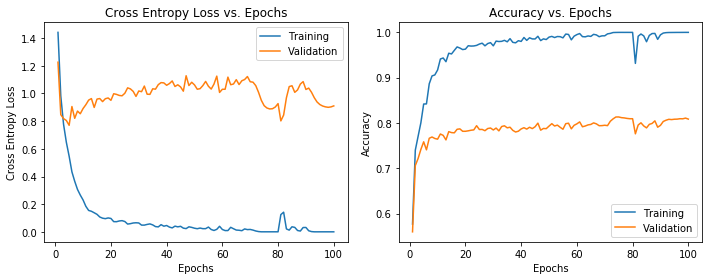

In [108]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(list(range(1,len(np.array(results)[:,2])+1)), np.array(results)[:,2], label='Training')
plt.plot(list(range(1,len(np.array(results)[:,3])+1)), np.array(results)[:,3], label='Validation')
plt.title('Cross Entropy Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(list(range(1,len(np.array(results)[:,0])+1)), np.array(results)[:,0], label='Training')
plt.plot(list(range(1,len(np.array(results)[:,1])+1)), np.array(results)[:,1], label='Validation')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

#plt.savefig('sgd_model_plot_batch_norm_hidden_256x256.png')
plt.show()